##### Copyright 2021 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Generate music with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/audio/music_generation"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/audio/music_generation.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/audio/music_generation.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/audio/music_generation.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial shows you how to generate musical notes using a simple recurrent neural network (RNN). You will train a model using a collection of piano MIDI files from the [MAESTRO dataset](https://magenta.tensorflow.org/datasets/maestro). Given a sequence of notes, your model will learn to predict the next note in the sequence. You can generate longer sequences of notes by calling the model repeatedly.

This tutorial contains complete code to parse and create MIDI files. You can learn more about how RNNs work by visiting the [Text generation with an RNN](https://www.tensorflow.org/text/tutorials/text_generation) tutorial.

## Setup

This tutorial uses the [`pretty_midi`](https://github.com/craffel/pretty-midi) library to create and parse MIDI files, and [`pyfluidsynth`](https://github.com/nwhitehead/pyfluidsynth) for generating audio playback in Colab.

In [2]:
!sudo apt install -y fluidsynth

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libevdev2 libfluidsynth3 libgudev-1.0-0 libinput-bin
  libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a libqt5dbus5
  libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libxcb-icccm4 libxcb-image0 libxcb-keysyms1
  libxcb-render-util0 libxcb-util1 libxcb-xinerama0 libxcb-xinput0 libxcb-xkb1
  libxkbcommon-x11-0 qsynth qt5-gtk-platformtheme qttranslations5-l10n
  timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs qt5-image-formats-plugins qtwayland5 jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libevdev2 libfluidsynth3 libgudev-1.0-0
  libinput-bin libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a
  libqt5dbus5 libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libx

In [3]:
!pip install --upgrade pyfluidsynth

  Preparing metadata (setup.py) ... done
  Created wheel for pyfluidsynth: filename=pyFluidSynth-1.3.3-py3-none-any.whl size=19185 sha256=81edfbcfa510b733fb62dfb6c85dd1d3d34d2785d88800bd3ed1157844663fd2
  Stored in directory: /root/.cache/pip/wheels/e6/9c/2b/b4b194cbb100d6f20136a22b2f76cd329b1a21139ed26c9775
Successfully built pyfluidsynth


In [4]:
!pip install pretty_midi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 27.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.8 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592289 sha256=ea9b62cbaddc33989d1a687adfe4b6d642f624f8e0a0962a82975af84565642b
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty_midi
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
      Successfully uninstalled packaging-24.0


In [5]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Optional

In [6]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

## Download the Maestro dataset

In [10]:
data_dir = pathlib.Path('data/maestro-v3.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v3.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v3.0.0/maestro-v3.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

The dataset contains about 1,200 MIDI files.

In [11]:
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1276


## Process a MIDI file

First, use ```pretty_midi``` to parse a single MIDI file and inspect the format of the notes. If you would like to download the MIDI file below to play on your computer, you can do so in colab by writing ```files.download(sample_file)```.


In [12]:
sample_file = filenames[1]
print(sample_file)

data/maestro-v3.0.0/2017/MIDI-Unprocessed_054_PIANO054_MID--AUDIO-split_07-07-17_Piano-e_1-02_wav--1.midi


Generate a `PrettyMIDI` object for the sample MIDI file.

In [13]:
pm = pretty_midi.PrettyMIDI(sample_file)

Play the sample file. The playback widget may take several seconds to load.

In [14]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [15]:
display_audio(pm)

Do some inspection on the MIDI file. What kinds of instruments are used?

In [16]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Acoustic Grand Piano


## Extract notes

In [17]:
sorted_notes = sorted(instrument.notes, key=lambda note: note.start)

for i, note in enumerate(sorted_notes[:10]):
    note_name = pretty_midi.note_number_to_name(note.pitch)
    duration = note.end - note.start
    velocity = note.velocity
    start = note.start

    # Calcular interval
    if i > 0:
        interval = start - sorted_notes[i - 1].start
    else:
        interval = 0

    # Calcular polyphony
    polyphony = sum((note.start <= other_note.start < note.end) or
                    (other_note.start <= note.start < other_note.end)
                    for other_note in instrument.notes) - 1

    print(f'{i}: pitch={note.pitch}, note_name={note_name}, duration={duration:.4f}, '
          f'velocity={velocity}, interval={interval:.4f}, polyphony={polyphony}')

0: pitch=45, note_name=A2, duration=0.5865, velocity=42, interval=0.0000, polyphony=5
1: pitch=72, note_name=C5, duration=0.1667, velocity=58, interval=0.1510, polyphony=2
2: pitch=74, note_name=D5, duration=0.1240, velocity=62, interval=0.1229, polyphony=3
3: pitch=76, note_name=E5, duration=0.2083, velocity=68, interval=0.0958, polyphony=4
4: pitch=77, note_name=F5, duration=0.4073, velocity=64, interval=0.1531, polyphony=4
5: pitch=57, note_name=A3, duration=0.6531, velocity=52, interval=0.0063, polyphony=6
6: pitch=72, note_name=C5, duration=0.3750, velocity=64, interval=0.2667, polyphony=4
7: pitch=56, note_name=G#3, duration=0.6250, velocity=50, interval=0.2448, polyphony=6
8: pitch=71, note_name=B4, duration=0.3333, velocity=61, interval=0.0052, polyphony=4
9: pitch=75, note_name=D#5, duration=0.4469, velocity=68, interval=0.2729, polyphony=4


You will use three variables to represent a note when training the model: `pitch`, `step` and `duration`. The pitch is the perceptual quality of the sound as a MIDI note number.
The `step` is the time elapsed from the previous note or start of the track.
The `duration` is how long the note will be playing in seconds and is the difference between the note end and note start times.


Extract the notes from the sample MIDI file.

In [18]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for i, note in enumerate(sorted_notes):
    start = note.start
    end = note.end
    pitch = note.pitch
    duration = end - start

    notes['pitch'].append(pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(duration)
    notes['velocity'].append(note.velocity)

    # Interval is the difference in start times between consecutive notes
    if i > 0:
        interval = start - sorted_notes[i - 1].start
    else:
        interval = 0
    notes['interval'].append(interval)

    # Calculate polyphony
    polyphony = sum((note.start <= other_note.start < note.end) or
                    (other_note.start <= note.start < other_note.end)
                    for other_note in instrument.notes) - 1
    notes['polyphony'].append(polyphony)

    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [19]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

pitch     start       end      step  duration  velocity  interval  \
0     45  1.020833  1.607292  0.000000  0.586458        42  0.000000   
1     72  1.171875  1.338542  0.151042  0.166667        58  0.151042   
2     74  1.294792  1.418750  0.122917  0.123958        62  0.122917   
3     76  1.390625  1.598958  0.095833  0.208333        68  0.095833   
4     77  1.543750  1.951042  0.153125  0.407292        64  0.153125   

   polyphony  
0          5  
1          2  
2          3  
3          4  
4          4

It may be easier to interpret the note names rather than the pitches, so you can use the function below to convert from the numeric pitch values to note names.
The note name shows the type of note, accidental and octave number
(e.g. C#4).

In [20]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['A2', 'C5', 'D5', 'E5', 'F5', 'A3', 'C5', 'G#3', 'B4', 'D#5'],
      dtype='<U3')

To visualize the musical piece, plot the note pitch, start and end across the length of the track (i.e. piano roll). Start with the first 100 notes

In [21]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

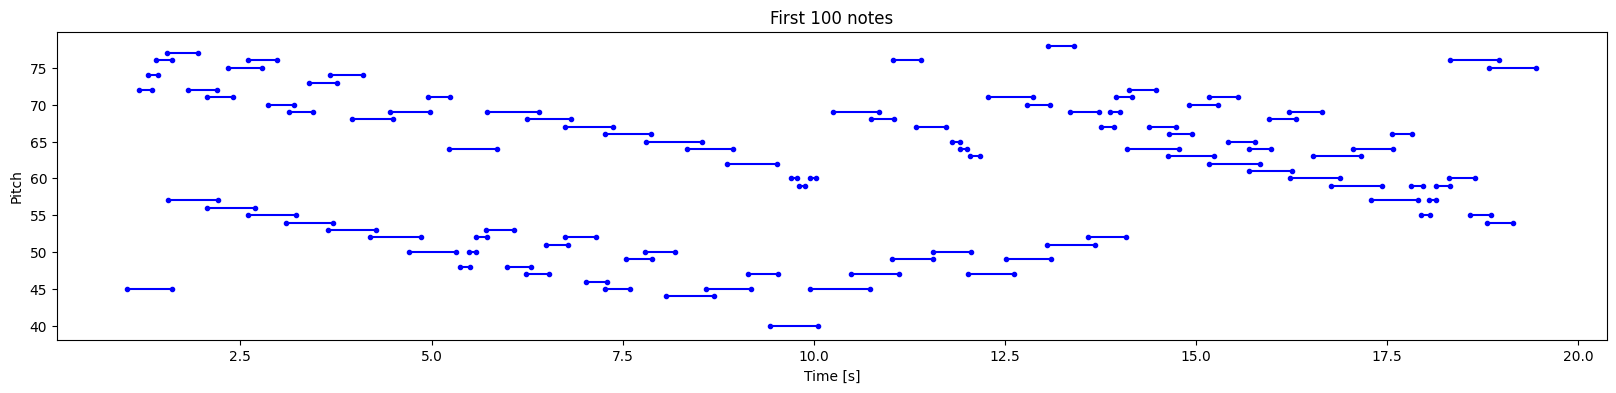

In [22]:
plot_piano_roll(raw_notes, count=100)

Plot the notes for the entire track.

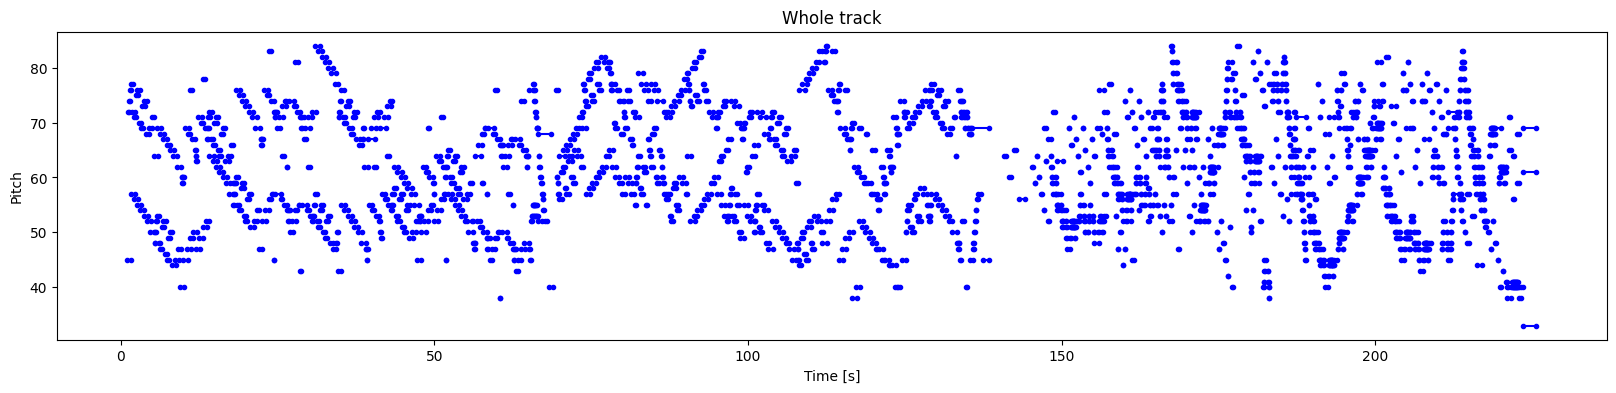

In [23]:
plot_piano_roll(raw_notes)

Check the distribution of each note variable.

In [24]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
    plt.figure(figsize=[20, 10])

    # Pitch
    plt.subplot(2, 3, 1)
    sns.histplot(notes, x="pitch", bins=20)
    plt.title("Pitch Distribution")

    # Step
    plt.subplot(2, 3, 2)
    max_step = np.percentile(notes['step'], 100 - drop_percentile)
    sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))
    plt.title("Step Distribution")

    # Duration
    plt.subplot(2, 3, 3)
    max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
    sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))
    plt.title("Duration Distribution")

    # Interval
    plt.subplot(2, 3, 4)
    max_interval = np.percentile(notes['interval'], 100 - drop_percentile)
    sns.histplot(notes, x="interval", bins=np.linspace(0, max_interval, 21))
    plt.title("Interval Distribution")

    # Velocity
    plt.subplot(2, 3, 5)
    sns.histplot(notes, x="velocity", bins=20)
    plt.title("Velocity Distribution")

    # Polyphony
    plt.subplot(2, 3, 6)
    sns.histplot(notes, x="polyphony", bins=20)
    plt.title("Polyphony Distribution")

    plt.tight_layout()
    plt.show()

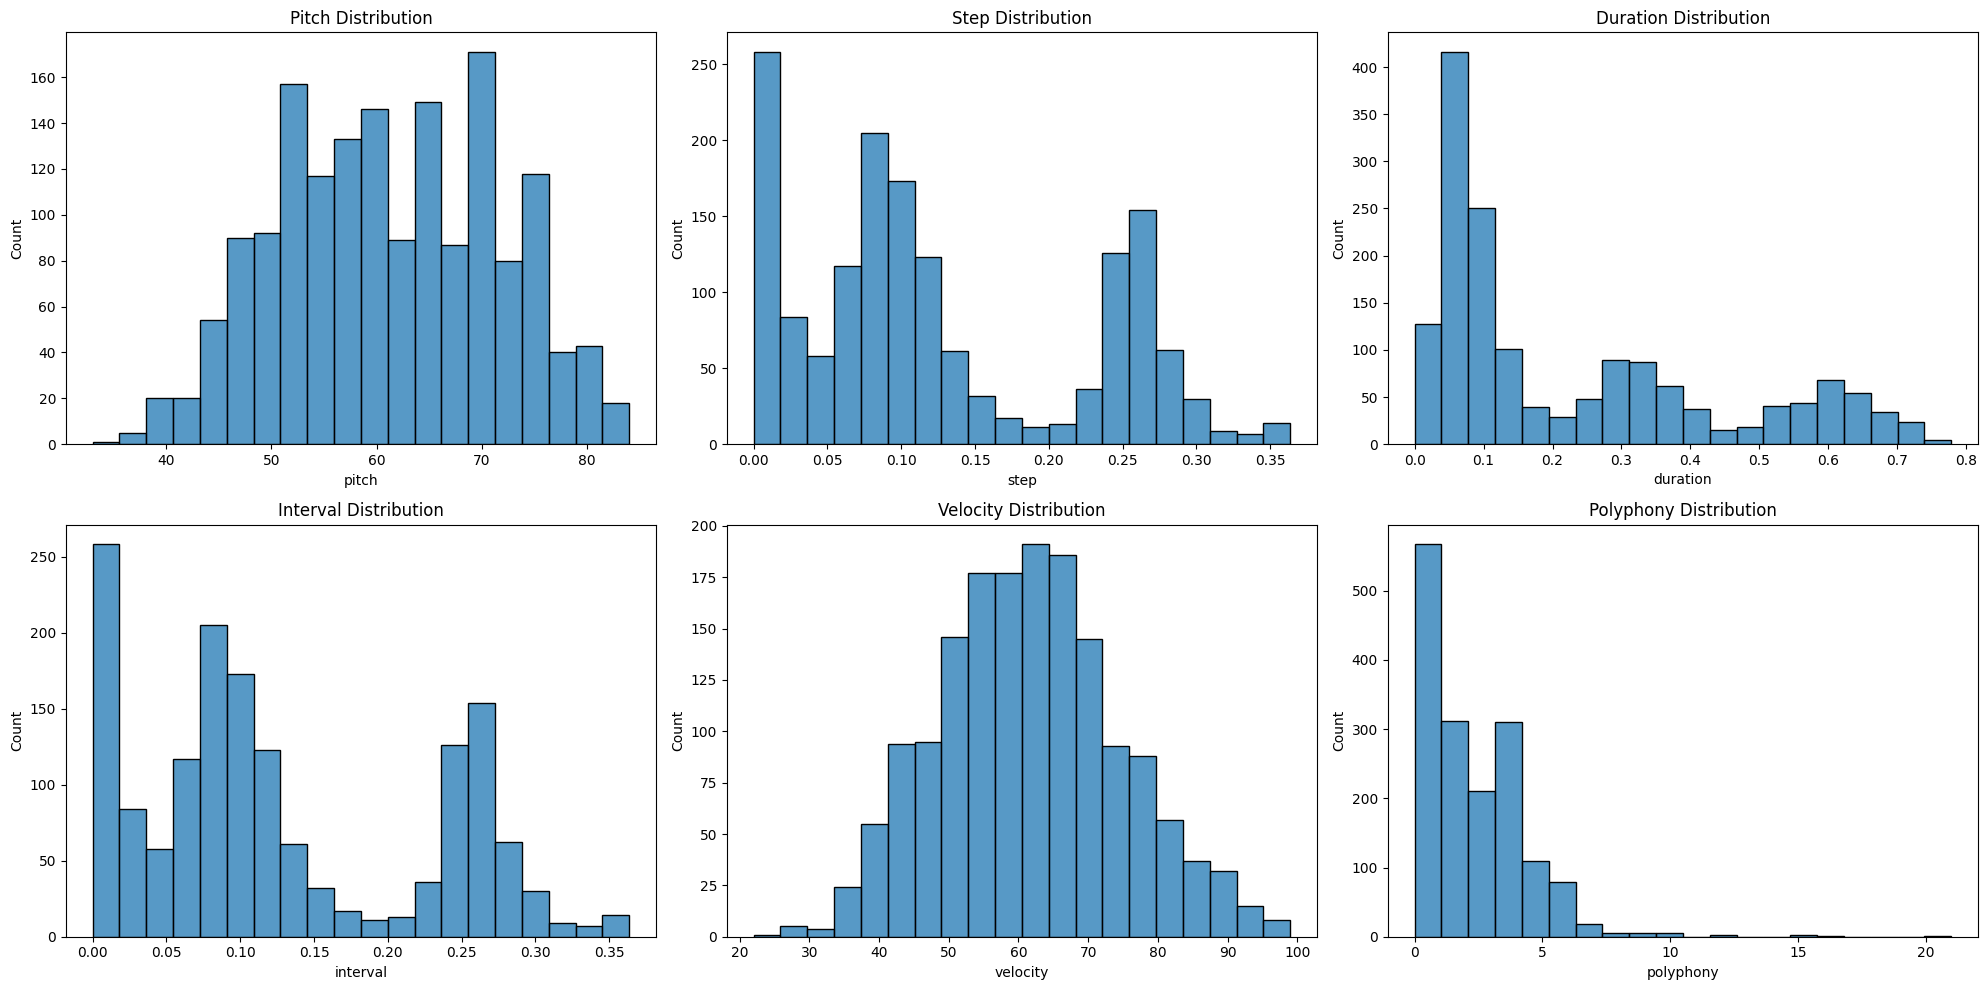

In [25]:
plot_distributions(raw_notes)

## Create a MIDI file

You can generate your own MIDI file from a list of notes using the function below.

In [26]:
def notes_to_midi(
    notes: pd.DataFrame,
    out_file: str,
    instrument_name: str,
    default_velocity: int = 100,  # note loudness por defecto
) -> pretty_midi.PrettyMIDI:

    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(
        program=pretty_midi.instrument_name_to_program(instrument_name))

    prev_start = 0
    for i, note in notes.iterrows():
        start = float(prev_start + note['step'])
        end = float(start + note['duration'])
        velocity = int(note['velocity']) if 'velocity' in notes.columns else default_velocity
        pitch = int(note['pitch'])

        midi_note = pretty_midi.Note(
            velocity=velocity,
            pitch=pitch,
            start=start,
            end=end,
        )
        instrument.notes.append(midi_note)
        prev_start = start

    pm.instruments.append(instrument)
    pm.write(out_file)
    return pm


In [27]:
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

Play the generated MIDI file and see if there is any difference.

In [28]:
display_audio(example_pm)

As before, you can write ```files.download(example_file)``` to download and play this file.

## Create the training dataset


Create the training dataset by extracting notes from the MIDI files. You can start by using a small number of files, and experiment later with more. This may take a couple minutes.

In [29]:
num_files = 5
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [30]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 23361


Next, create a `tf.data.Dataset` from the parsed notes.

In [31]:
key_order = ['pitch', 'step', 'duration', 'velocity', 'interval', 'polyphony']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [40]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(6,), dtype=tf.float64, name=None)

You will train the model on batches of sequences of notes. Each example will consist of a sequence of notes as the input features, and the next note as the label. In this way, the model will be trained to predict the next note in a sequence. You can find a diagram describing this process (and more details) in [Text classification with an RNN](https://www.tensorflow.org/text/tutorials/text_generation).

You can use the handy [window](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#window) function with size `seq_length` to create the features and labels in this format.

In [60]:
seq_length = 25

def create_sequences(
    dataset: tf.data.Dataset,
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x / [vocab_size, 1.0, 1.0, 1.0, 1.0, 1.0]
    return x

  # Split the labels
  def split_labels(sequences):
      inputs = sequences[:-1]
      labels_dense = sequences[-1]
      labels = {key: labels_dense[i] for i, key in enumerate(key_order)}

      # Ensure polyphony labels are in the correct range
      labels['polyphony'] = tf.clip_by_value(labels['polyphony'], 0, 12)

      return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

Set the sequence length for each example. Experiment with different lengths (e.g. 50, 100, 150) to see which one works best for the data, or use [hyperparameter tuning](https://www.tensorflow.org/tutorials/keras/keras_tuner). The size of the vocabulary (`vocab_size`) is set to 128 representing all the pitches supported by `pretty_midi`.

In [61]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 6), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'velocity': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'interval': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'polyphony': TensorSpec(shape=(), dtype=tf.float64, name=None)})

The shape of the dataset is ```(100,1)```, meaning that the model will take 100 notes as input, and learn to predict the following note as output.

In [62]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (25, 6)
sequence elements (first 10): tf.Tensor(
[[3.12500000e-01 0.00000000e+00 2.92708333e-01 9.10000000e+01
  0.00000000e+00 1.00000000e+00]
 [3.67187500e-01 2.50000000e-01 7.50000000e-02 7.20000000e+01
  2.50000000e-01 1.00000000e+00]
 [4.29687500e-01 1.26041667e-01 8.02083333e-02 7.20000000e+01
  1.26041667e-01 0.00000000e+00]
 [4.21875000e-01 8.12500000e-02 7.70833333e-02 7.60000000e+01
  8.12500000e-02 0.00000000e+00]
 [4.29687500e-01 1.09375000e-01 7.29166667e-02 7.40000000e+01
  1.09375000e-01 1.00000000e+00]
 [4.06250000e-01 6.87500000e-02 8.54166667e-02 7.10000000e+01
  6.87500000e-02 1.00000000e+00]
 [4.29687500e-01 1.09375000e-01 1.21875000e-01 6.70000000e+01
  1.09375000e-01 1.00000000e+00]
 [4.06250000e-01 1.00000000e-01 8.33333333e-02 7.20000000e+01
  1.00000000e-01 2.00000000e+00]
 [3.98437500e-01 7.81250000e-02 7.91666667e-02 7.50000000e+01
  7.81250000e-02 1.00000000e+00]
 [4.29687500e-01 8.85416667e-02 5.52083333e-02 7.40000000e+01
  8.85416667e-02 0

Batch the examples, and configure the dataset for performance.

In [63]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [64]:
train_ds.element_spec

(TensorSpec(shape=(64, 25, 6), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'velocity': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'interval': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'polyphony': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

## Create and train the model

The model will have three outputs, one for each note variable. For `step` and `duration`, you will use a custom loss function based on mean squared error that encourages the model to output non-negative values.

In [65]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [66]:
num_features = 6  # The number of features per timestep
input_shape = (seq_length, num_features)

learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
  'interval': tf.keras.layers.Dense(1, name='interval')(x),
  'velocity': tf.keras.layers.Dense(1, name='velocity')(x),
  'polyphony': tf.keras.layers.Dense(13, activation='softmax', name='polyphony')(x),
}

model = tf.keras.Model(inputs, outputs)

def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
      'interval': mse_with_positive_pressure,
      'velocity': mse_with_positive_pressure,
      'polyphony': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 25, 6)]              0         []                            
                                                                                                  
 lstm_2 (LSTM)               (None, 128)                  69120     ['input_3[0][0]']             
                                                                                                  
 duration (Dense)            (None, 1)                    129       ['lstm_2[0][0]']              
                                                                                                  
 interval (Dense)            (None, 1)                    129       ['lstm_2[0][0]']              
                                                                                            

Testing the `model.evaluate` function, you can see that the `pitch` loss is significantly greater than the `step` and `duration` losses.
Note that `loss` is the total loss computed by summing all the other losses and is currently dominated by the `pitch` loss.

In [67]:
losses = model.evaluate(train_ds, return_dict=True)
losses

364/364 [==============================] - 14s 19ms/step - loss: 4711.8999 - duration_loss: 0.1515 - interval_loss: 0.2626 - pitch_loss: 4.9692 - polyphony_loss: 2.5480 - step_loss: 12.9432 - velocity_loss: 4691.0269


{'loss': 4711.89990234375,
 'duration_loss': 0.1515062302350998,
 'interval_loss': 0.2626427710056305,
 'pitch_loss': 4.969172954559326,
 'polyphony_loss': 2.5479795932769775,
 'step_loss': 12.943154335021973,
 'velocity_loss': 4691.02685546875}

One way balance this is to use the `loss_weights` argument to compile:

In [68]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 1.0,
        'step': 1.0,
        'duration':1.0,
        'interval': 0.5,  # Larger loss, but not as large as velocity, moderate weight
        'velocity': 0.1,  # Very large loss, significantly reduce weight
        'polyphony': 1.0,

    },
    optimizer=optimizer,
)

The `loss` then becomes the weighted sum of the individual losses.

In [69]:
model.evaluate(train_ds, return_dict=True)

364/364 [==============================] - 10s 22ms/step - loss: 489.8459 - duration_loss: 0.1515 - interval_loss: 0.2626 - pitch_loss: 4.9692 - polyphony_loss: 2.5480 - step_loss: 12.9432 - velocity_loss: 4691.0269


{'loss': 489.84588623046875,
 'duration_loss': 0.1515062302350998,
 'interval_loss': 0.2626427710056305,
 'pitch_loss': 4.969172954559326,
 'polyphony_loss': 2.5479795932769775,
 'step_loss': 12.943154335021973,
 'velocity_loss': 4691.02685546875}

Train the model.

In [70]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [71]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50
364/364 [==============================] - 57s 48ms/step - loss: 86.3463 - duration_loss: 0.2117 - interval_loss: 0.1294 - pitch_loss: 4.0239 - polyphony_loss: 2.1040 - step_loss: 0.1989 - velocity_loss: 797.4311
Epoch 2/50
364/364 [==============================] - 19s 52ms/step - loss: 22.4417 - duration_loss: 0.1240 - interval_loss: 0.0442 - pitch_loss: 3.9765 - polyphony_loss: 2.0647 - step_loss: 0.0454 - velocity_loss: 162.0904
Epoch 3/50
364/364 [==============================] - 17s 47ms/step - loss: 21.5890 - duration_loss: 0.1188 - interval_loss: 0.0459 - pitch_loss: 3.9615 - polyphony_loss: 2.0386 - step_loss: 0.0337 - velocity_loss: 154.1351
Epoch 4/50
364/364 [==============================] - 17s 48ms/step - loss: 21.4941 - duration_loss: 0.1155 - interval_loss: 0.0480 - pitch_loss: 3.9544 - polyphony_loss: 2.0178 - step_loss: 0.0402 - velocity_loss: 153.4223
Epoch 5/50
364/364 [==============================] - 18s 48ms/step - loss: 21.3141 - duration_loss: 0.1

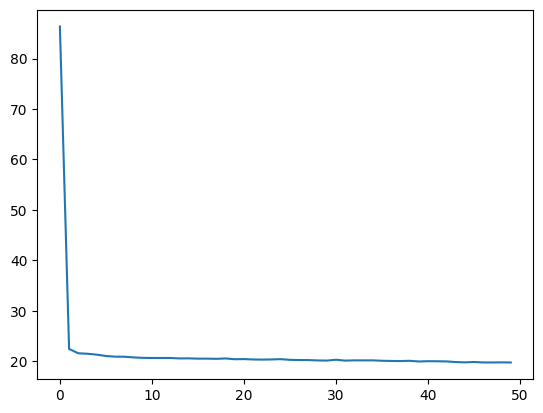

In [72]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

## Generate notes

To use the model to generate notes, you will first need to provide a starting sequence of notes. The function below generates one note from a sequence of notes.

For note pitch, it draws a sample from the softmax distribution of notes produced by the model, and does not simply pick the note with the highest probability.
Always picking the note with the highest probability would lead to repetitive sequences of notes being generated.

The `temperature` parameter can be used to control the randomness of notes generated. You can find more details on temperature in [Text generation with an RNN](https://www.tensorflow.org/text/tutorials/text_generation).

In [78]:
def predict_next_note(
    notes: np.ndarray,
    model: tf.keras.Model,
    temperature: float = 1.0) -> tuple[int, float, float, int, float, int]:
  """Generates a note as a tuple of (pitch, step, duration, velocity, interval, polyphony), using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']
  velocity = predictions['velocity']
  interval = predictions['interval']
  polyphony_logits = predictions['polyphony']

  # Apply temperature to pitch and polyphony logits
  pitch_logits /= temperature
  polyphony_logits /= temperature

  # Sample from the distributions
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  polyphony = tf.random.categorical(polyphony_logits, num_samples=1)

  # Squeeze dimensions
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)
  velocity = tf.squeeze(velocity, axis=-1)
  interval = tf.squeeze(interval, axis=-1)
  polyphony = tf.squeeze(polyphony, axis=-1)

  # Ensure `step` and `duration` values are non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration), int(velocity), float(interval), int(polyphony)

Now generate some notes. You can play around with temperature and the starting sequence in `next_notes` and see what happens.

In [79]:
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training sequences
input_notes = sample_notes[:seq_length] / np.array([vocab_size, 1, 1, 1, 1, 1])

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration, velocity, interval, polyphony = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration, velocity, interval, polyphony)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

# Mostrar los datos generados
print(generated_notes.head())

1/1 [==============================] - 0s 31ms/step
   pitch      step  duration  velocity  interval  polyphony     start  \
0     69  0.115120  0.378439        48  0.108893          6  0.115120   
1     52  0.710311  1.078344        24  0.501008          8  0.825431   
2     46  0.514666  0.850910        24  0.274529          7  1.340097   
3     60  0.539136  0.871547        22  0.306567          1  1.879233   
4     67  0.552111  0.905502        18  0.341810         12  2.431344   

        end  
0  0.493559  
1  1.903775  
2  2.191007  
3  2.750780  
4  3.336846  


In [80]:
generated_notes.head(10)

pitch      step  duration  velocity  interval  polyphony     start  \
0     69  0.115120  0.378439        48  0.108893          6  0.115120   
1     52  0.710311  1.078344        24  0.501008          8  0.825431   
2     46  0.514666  0.850910        24  0.274529          7  1.340097   
3     60  0.539136  0.871547        22  0.306567          1  1.879233   
4     67  0.552111  0.905502        18  0.341810         12  2.431344   
5     72  0.476715  0.950560        18  0.260779          8  2.908059   
6      7  0.489318  0.825648        16  0.320767          7  3.397376   
7     67  0.403784  0.971203        27  0.285034          2  3.801160   
8     66  0.536236  0.895289        16  0.328548          3  4.337396   
9     81  0.526276  0.876483        16  0.328543          9  4.863673   

        end  
0  0.493559  
1  1.903775  
2  2.191007  
3  2.750780  
4  3.336846  
5  3.858618  
6  4.223024  
7  4.772363  
8  5.232685  
9  5.740155

In [81]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

You can also download the audio file by adding the two lines below:

```
from google.colab import files
files.download(out_file)
```

Visualize the generated notes.

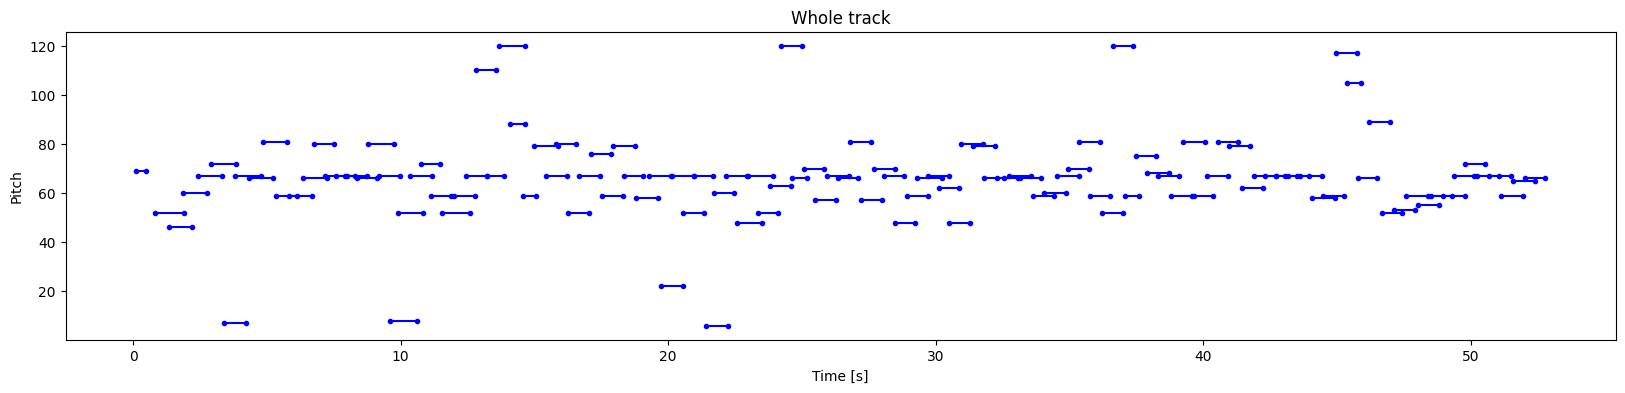

In [83]:
plot_piano_roll(generated_notes)

Check the distributions of `pitch`, `step` and `duration`.

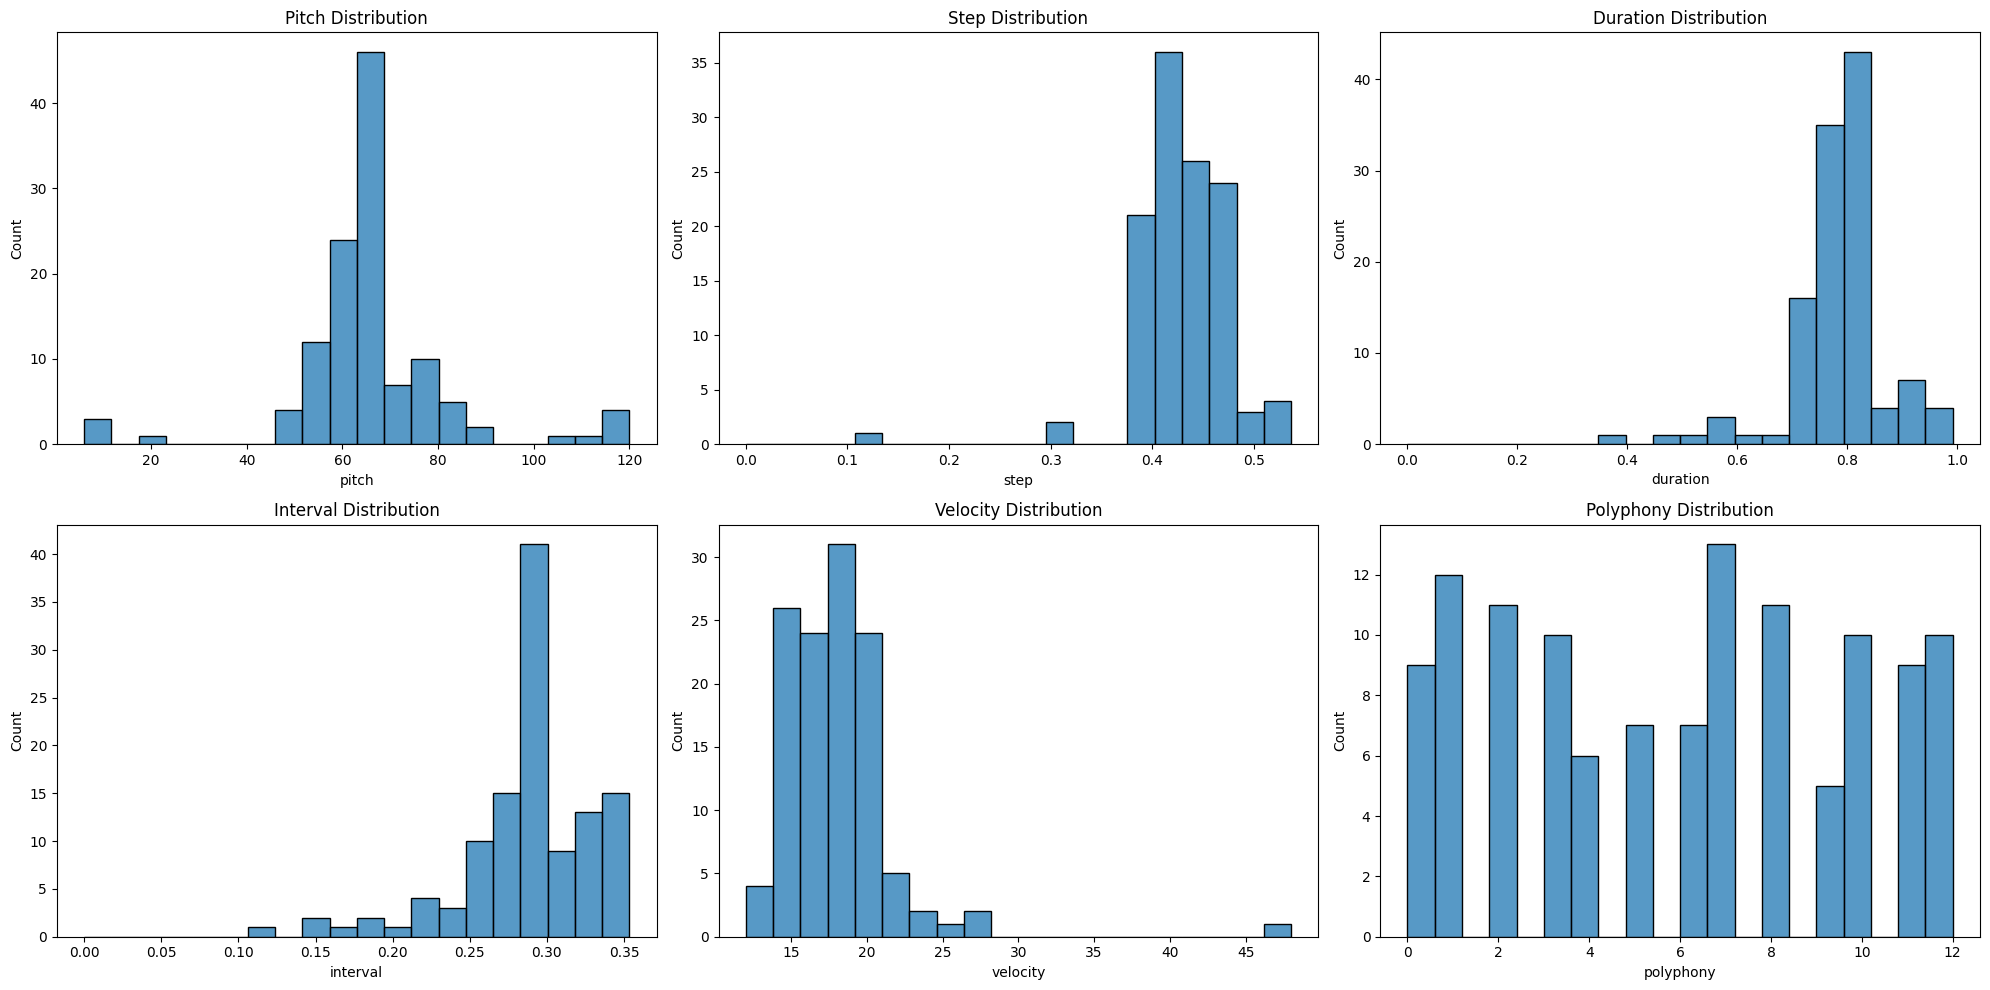

In [84]:
plot_distributions(generated_notes)

In the above plots, you will notice the change in distribution of the note variables.
Since there is a feedback loop between the model's outputs and inputs, the model tends to generate similar sequences of outputs to reduce the loss.
This is particularly relevant for `step` and `duration`, which uses the MSE loss.
For `pitch`, you can increase the randomness by increasing the `temperature` in `predict_next_note`.


In [99]:
!pip install midi2audio

In [100]:
from midi2audio import FluidSynth

# Convertir el archivo MIDI a WAV usando FluidSynth
wav_file = 'output.wav'
fs = FluidSynth()
fs.midi_to_audio(out_file, wav_file)

# Verificar que el archivo WAV se ha creado
if os.path.exists(wav_file):
    print(f"Archivo WAV creado: {wav_file}")
else:
    print("Error al crear el archivo WAV")

Archivo WAV creado: output.wav


In [101]:
from google.colab import files

# Descargar el archivo MP3
files.download(wav_file)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Next steps

This tutorial demonstrated the mechanics of using an RNN to generate sequences of notes from a dataset of MIDI files. To learn more, you can visit the closely related [Text generation with an RNN](https://www.tensorflow.org/text/tutorials/text_generation) tutorial, which contains additional diagrams and explanations.

One of the alternatives to using RNNs for music generation is using GANs. Rather than generating audio, a GAN-based approach can generate an entire sequence in parallel. The Magenta team has done impressive work on this approach with [GANSynth](https://magenta.tensorflow.org/gansynth). You can also find many wonderful music and art projects and open-source code on [Magenta project website](https://magenta.tensorflow.org/).